##  Подбор параметров

Подберём параметр $k:$
$$
\lambda(\delta) = A e^{-k\delta}
$$где $\lambda(\delta)$ -- интенсивность исполнения наших заявок при условии, что заявка стоит на расстоянии $\delta$ от мид прайса, $A$ -- нормировочная константа. 

Введём сетку по $\delta: 0 < \delta_0 < \ldots < \delta_{K-1}$ и для каждого $\delta_i$ посчитаем, сколько рыночных заявок пробило стакан больше, чем на $\delta_i$. Обозначим это число через $N_i$. Тогда константу $k$ можно найти из линейной регрессии:
$$
\log N_i = -k \delta_i + C
$$при $C = \log A$

При решении первого ДЗ я уже считал эти статистики, а именно на сколько каждая рыночная заявка пробивает стакан.

In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [39]:
bid_trades_group = pd.read_csv("../md/bid_trades_group.csv")
ask_trades_group = pd.read_csv("../md/ask_trades_group.csv")

bid_trades_group["exchange_dt"] = pd.to_datetime(bid_trades_group["exchange_dt"])
ask_trades_group["exchange_dt"] = pd.to_datetime(ask_trades_group["exchange_dt"])

Под маркет одером я понимаю сделки, произведённые в один и тот же `exchange_ts`. В этом датасете `size` -- суммарный размер маркет ордера, `mean_price` -- средневзвешенная цена, `first_price, last_price` -- первая и последняя цена покупки, `delta` -- их разница, по сути величина пробития стакана.

In [40]:
display(bid_trades_group.head(5))

,exchange_dt,size,mean_price,first_price,last_price,delta,n_trades,nunique_price
0,2022-06-23 00:00:02.623,0.001,19977.500000,19977.5,19977.5,0.0,1.0,0.0
1,2022-06-23 00:00:05.292,0.086,19977.530233,19977.5,19978.0,0.5,7.0,3.0
2,2022-06-23 00:00:09.193,0.150,19978.000000,19978.0,19978.0,0.0,4.0,0.0
3,2022-06-23 00:00:09.198,0.199,19978.000000,19978.0,19978.0,0.0,1.0,0.0
4,2022-06-23 00:00:09.202,0.167,19978.000000,19978.0,19978.0,0.0,3.0,0.0


In [41]:
display(ask_trades_group.head(5))

,exchange_dt,size,mean_price,first_price,last_price,delta,n_trades,nunique_price
0,2022-06-23 00:00:08.890,0.020,19977.9,19977.9,19977.9,0.0,1.0,0.0
1,2022-06-23 00:00:09.193,0.233,19977.9,19977.9,19977.9,0.0,2.0,0.0
2,2022-06-23 00:00:09.233,0.032,19977.9,19977.9,19977.9,0.0,1.0,0.0
3,2022-06-23 00:00:09.244,0.021,19977.9,19977.9,19977.9,0.0,1.0,0.0
4,2022-06-23 00:00:09.253,0.010,19977.9,19977.9,19977.9,0.0,1.0,0.0


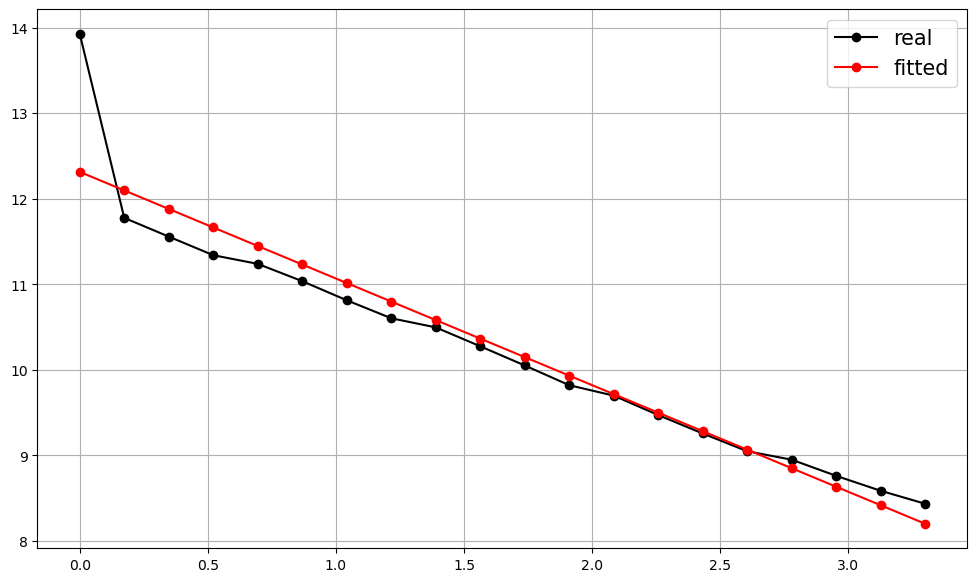

scale:  -1.2461632499213062


In [42]:
delta = ask_trades_group.delta.values
dmax = np.quantile(delta[delta > 0], 0.97)

deltas = np.linspace(0, dmax, 20)

res = np.zeros_like(deltas)

for i, d in enumerate(deltas):
    res[i] = np.sum( delta >= d )

scale, loc = np.polyfit(deltas, np.log(res), deg=1)
    
y = loc + deltas * scale

plt.figure(figsize=(12, 7))
plt.plot(deltas, np.log(res), '-ok', label='real')
plt.plot(deltas, y, '-or', label='fitted')
plt.grid()
plt.legend(fontsize=15)
plt.show()

print("scale: ", scale)

Тоже самое, но с выброшенной первой точкой $\delta = 0$

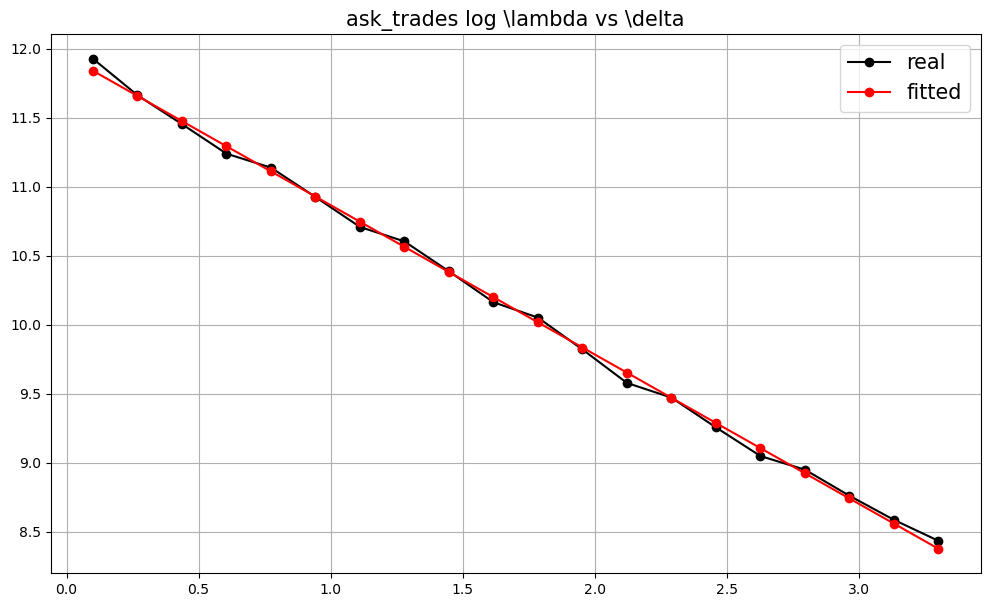

scale:  -1.081779931533557


In [43]:
delta = ask_trades_group.delta.values
dmin = np.min(delta[delta > 0])
dmax = np.quantile(delta[delta > 0], 0.97)

deltas = np.linspace(dmin, dmax, 20)

res = np.zeros_like(deltas)

for i, d in enumerate(deltas):
    res[i] = np.sum( delta >= d )

scale, loc = np.polyfit(deltas, np.log(res), deg=1)
    
y = loc + deltas * scale

plt.figure(figsize=(12, 7))
plt.title("ask_trades log \lambda vs \delta", fontsize=15)
plt.plot(deltas, np.log(res), '-ok', label='real')
plt.plot(deltas, y, '-or', label='fitted')
plt.grid()
plt.legend(fontsize=15)
plt.show()

print("scale: ", scale)

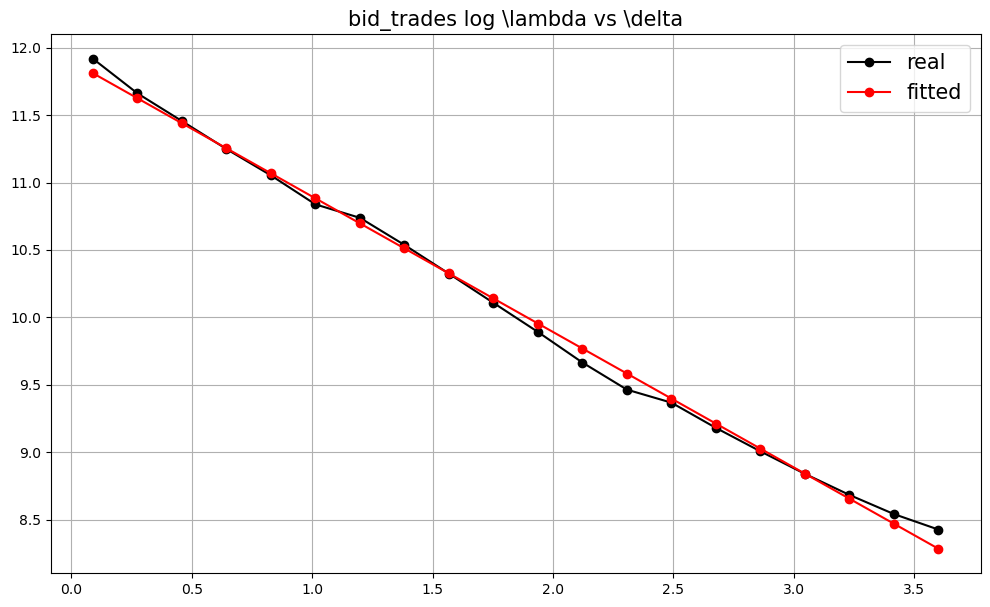

scale:  -1.0045402336999556


In [44]:
delta = bid_trades_group.delta.values
dmin = np.min(delta[delta > 0])
dmax = np.quantile(delta[delta > 0], 0.97)

deltas = np.linspace(dmin, dmax, 20)

res = np.zeros_like(deltas)

for i, d in enumerate(deltas):
    res[i] = np.sum( delta >= d )

scale, loc = np.polyfit(deltas, np.log(res), deg=1)
    
y = loc + deltas * scale

plt.figure(figsize=(12, 7))
plt.title("bid_trades log \lambda vs \delta", fontsize=15)
plt.plot(deltas, np.log(res), '-ok', label='real')
plt.plot(deltas, y, '-or', label='fitted')
plt.grid()
plt.legend(fontsize=15)
plt.show()

print("scale: ", scale)

Видно, что логарифм хорошо приближается линейной функцией. В качестве константы положим $k = 1 \$^{-1}$.

Вместо $T-t$ я буду везде в коде писать $T$, т.е. буду считать, что экспирация всегда происходит через $T$ наносекунд от настоящего.

Будем предполагать, что мид прайс есть геометрическое броуновское движение:
$$
\dfrac{dS_t}{S_t} = \sigma dW_t
$$

Пусть есть последовательность наблюдений цен $S_{t_0}, S_{t_1}, \ldots, S_{t_N}$. Построим лог-приращения:
$$
\Delta X_i = \log \dfrac{S_{t_{i+1}}}{S_{t_i}}
$$
Тогда $\dfrac{\Delta X_i}{\sqrt{\left(t_{i+1}-t_i\right)}} \sim N(\mu, \sigma^2 )$ и независимы. Сигму можно оценить как выборочное отклонение $\dfrac{\Delta X_i}{\sqrt{\left(t_{i+1}-t_i\right)}}$.

In [1]:
from simulator import Sim
from strategy_stoikov import StoikovStrategy
from get_info import get_pnl
from load_data import load_md_from_file


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

PATH_TO_FILE = '../md/btcusdt:Binance:LinearPerpetual/'
T = pd.Timedelta(10, 'm').delta

In [2]:
md = load_md_from_file(path=PATH_TO_FILE, T=T)

In [3]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

#delay between orders
delay = pd.Timedelta(0.05, 's').delta

In [ ]:
results = {}
gammas = [0.01, 0.5, 1.0, 2.0]

for gamma in [0.01, 0.5, 1.0, 2.0]:

    strategy = StoikovStrategy(delay, gamma=gamma, k=1.0, T = pd.Timedelta(1, 's').delta)

    res = strategy.run(sim = Sim(md, latency, md_latency))
    
    results[gamma] = get_pnl(res['updates'])

In [ ]:
plt.figure(figsize=(10, 5))

for gamma in gammas:
    df = results[gamma]

    dt = pd.to_datetime(df.receive_ts)

    
    plt.step(dt, df.total, '-', label=f'gamma={gamma}')

plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("Stoikov Strategy BTC pos", fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))

for gamma in gammas:
    df = results[gamma]

    dt = pd.to_datetime(df.receive_ts)

    
    plt.step(dt, df.BTC, '-', label=f'gamma={gamma}')

plt.xlabel("time", fontsize=13)
plt.ylabel("BTC pos", fontsize=13)
plt.title("Stoikov Strategy BTC pos", fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

In [ ]:
res.keys()

In [ ]:
spread = res['spread']
spread = spread[~np.isnan(spread)]

In [ ]:
i = slice(100, 600, 1)

In [ ]:
plt.figure(figsize=(10, 5))

plt.step(res['mid_price'][i], 'k-',label='mid price')
plt.step(res['res_price'][i], 'k-',label='reservation price')
plt.step(res['res_price'][i] + 0.5 * res['spread'][i], 'r-',alpha=0.5, label='Stoikov pos')
plt.step(res['res_price'][i] - 0.5 * res['spread'][i], 'r-',alpha=0.5)
plt.step(res['bid_price'][i], 'g--', alpha=0.5, label='best pos')
plt.step(res['ask_price'][i], 'g--', alpha=0.5)
plt.grid()
plt.legend()
plt.show()